# Sequences, Time Series and Prediction in TensorFlow

### Notes from the Deeplearning.ai Specialization in Coursera, as taught by Andrew Ng and Laurence Muroney

### By Carlos Santillán

#### July 2020

# Week 1

## 1.1. Sequences and Prediction

Time series are everywhere:

- Weather forecasts

- Stock market data

**What are Time Series?**

- We can consider them as points of data in a given time with always the same size in time jump.

- They can be univariate or multivariate

    - Consider for example the movement of a car, we can look at it as a combination of lattitude and longitude coordinates, while accelaration may change the size of the time step

### 1.1.2. Machine Learning applied to Time Series

- The first and most obvious, is to forecast

- We can also project back into the past (**imputation**)

- Detect anomalies, for example website logs.

- Spot patterns, for example sound waves

### 1.1.3. Common patterns in time series

1. First we have **trend**

2. **Seasonality** is when a pattern repeats over a period of time

3. They can have a combination of this factors

4. Then we have **white noise**, which is basically random behavior

5. We say we have an **Autocorrelated** Time Series when it is correlated with itself, usually correlated with a lag of the original series.

Usually Time Series will have Trend + Seasonality + Autocorrelation + Noise


We will also deal with **Non-stationary** Time Series, which would basically means that it´s behavior has changed over time.

   - With this type of time Series the usual procedure is to train only on the most recent behavior, but this may go against the principle of "the more data we have, the better"
    
   - Taking all the Time Series is something that we will only be able to do with a **stationary** Time Series

### 1.1.4. Introduction to Time Series in Python



Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    '''
    INPUT: time
    INPUT: series
    INPUT: format
    INPUT: start
    INPUT: end
    INPUT: label
    
    OUTPUT: plot of the Time Series
    '''
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

Trend & Seasonality

In [ ]:
def trend(time, slope=0):
    return slope * time

Let's create a time series that just trends upward:

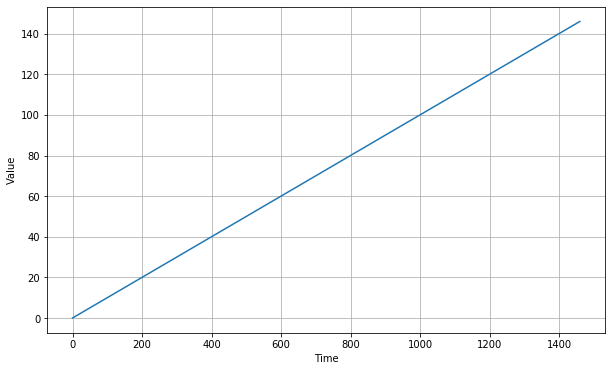

In [ ]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now let's generate a Time Series with a seasonal pattern:

In [ ]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

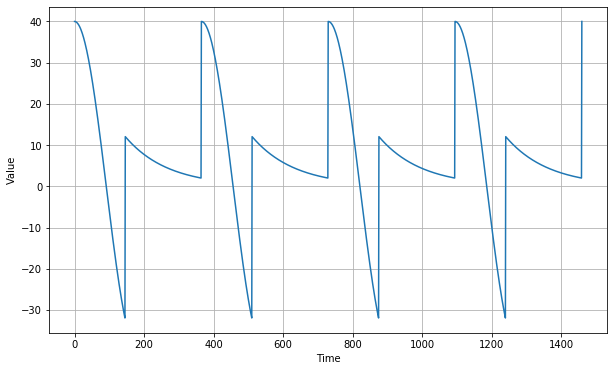

In [ ]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now let's create a Time Series with both trend and seasonality:

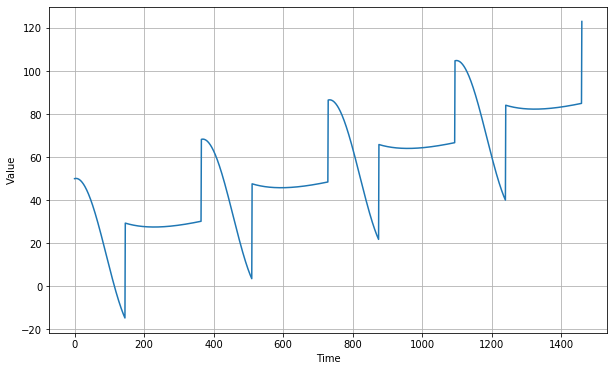

In [ ]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Noise

In practice few real-life time series have such a smooth signal. They usually have some noise, and the signal-to-noise ratio can sometimes be very low. Let's generate some white noise:

In [ ]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

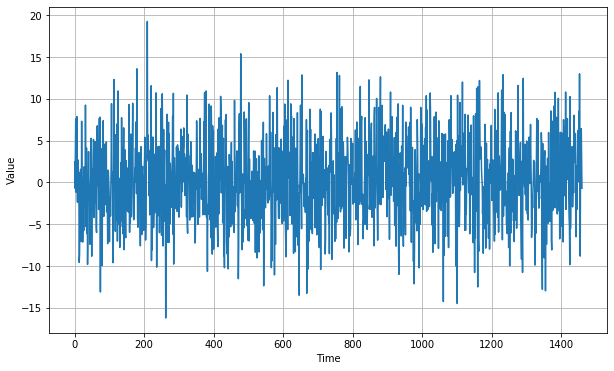

In [ ]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

Now let's add white noise to the time series:


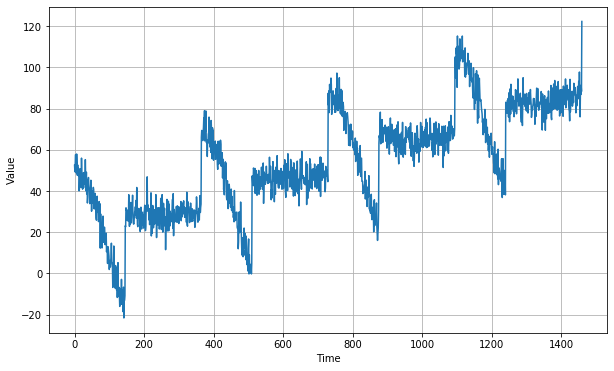

In [ ]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

All right, this looks realistic enough for now. Let's try to forecast it. We will split it into two periods: the training period and the validation period (in many cases, you would also want to have a test period). THe split will be at time step 1000.

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude

In [ ]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
    return ar[1:] * amplitude

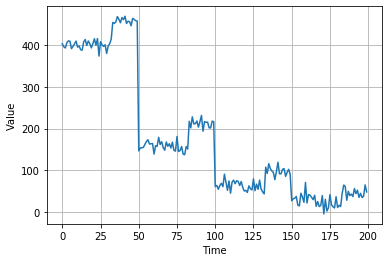

In [ ]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

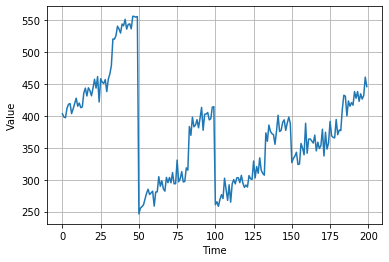

In [ ]:
series = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

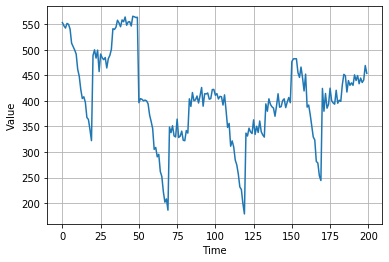

In [ ]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

Let us add an event that drastically changes the behavior of the time series, think of a crash in the stock market:

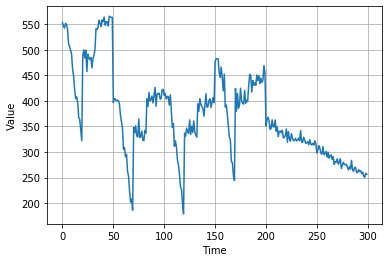

In [ ]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]
#series += noise(time, 30)
plot_series(time[:300], series[:300])
plt.show()

In [ ]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series    

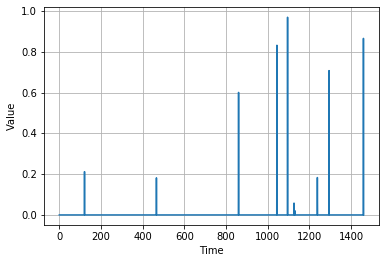

In [ ]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

In [ ]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
              ar[step] += φ * ar[step - lag]
    return ar

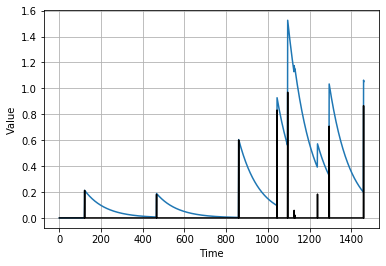

In [ ]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

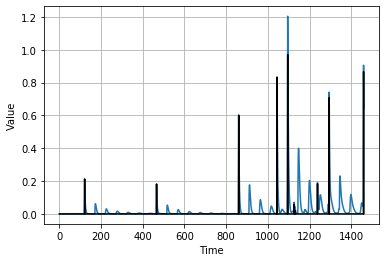

In [ ]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

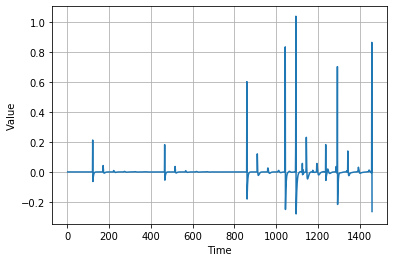

In [ ]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

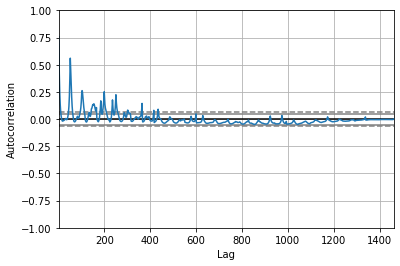

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


C:\Users\SANTICA4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1460
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2223.428
Method:                       css-mle   S.D. of innovations              0.053
Date:                Wed, 22 Jul 2020   AIC                          -4432.855
Time:                        21:39:26   BIC                          -4395.852
Sample:                             1   HQIC                         -4419.052
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.384      0.701      -0.001       0.002
ar.L1.D.y     -0.1235      0.026     -4.714      0.000      -0.175      -0.072
ar.L2.D.y     -0.1254      0.029     -4.333      0.0

### 1.1.5. Train, validation and test sets

Naive forecasting could be to take the last seen value and assume it will appear again.

Usually we want to partition the time series:

![Capture1.PNG](attachment:Capture1.PNG)

We often take the Test Period to be into the future, so we only split into Training Period and Validation Period.

We can also do some Roll-Forward Partitioning, which consists of training more data on every iteration.

### 1.1.6. Metrics for evaluating performance

- errors = forecast - actual

- mse = np.square(errors).mean()

- rmse = np.sqrt(mse)

- mae = np.abs(errors).mean()

- mape = np.abs(errors / x_valid).mean()

Most used is the MSE (Mean Squared Error) so that our errors do not cancel each other out.

By taking de RMSE we then return to the same scale of the errors.

MAE doesn´t penalize large errors as much as MSE does



### 1.1.7. Moving average and differencing

A common and very simple forecasting method is the Moving Average, this eliminates a lot of noise but doesn´t anticipate trend or seasonality.

To avoid this we need to remove the trend and seasonality from the Time Series by **differencing**

Before moving into Deep Learning always remember: **simple approaches often work the best**

### 1.1.8. Trailing vs. Centered Windows

To smooth past values we can use centered windows

### 1.1.9. Forecasting

Statistical forecasting should give us some form of baseline to see if we can improve it with Machine Learning Techniques

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.2.0


The next code block will set up the time series with seasonality, trend and a bit of noise

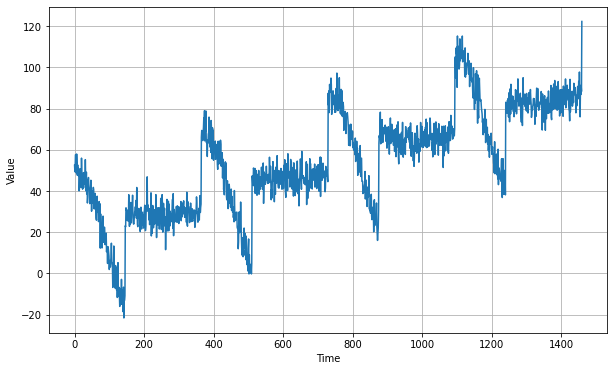

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now that we have the time series, let´s split it so we can start forecasting

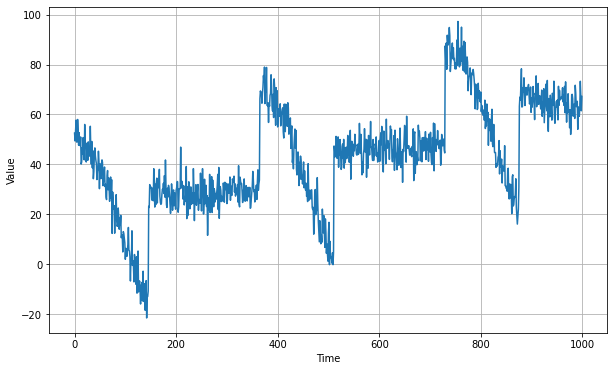

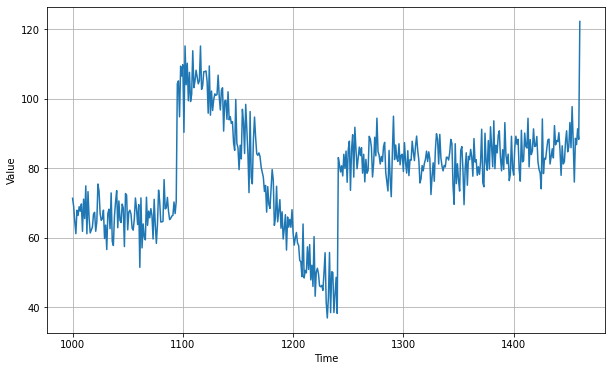

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

### Naive Forecast

In [ ]:
naive_forecast = series[split_time - 1:-1]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

NameError: ignored

Let's zoom in on the start of the validation period:

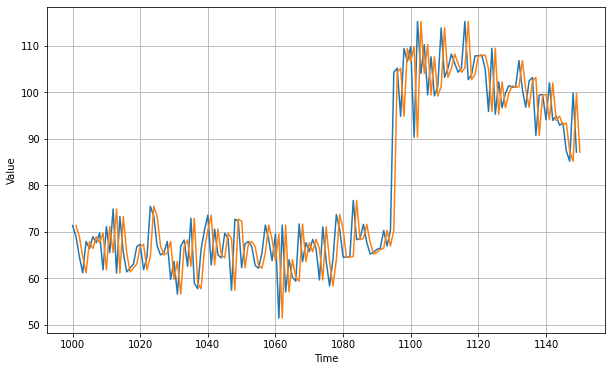

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

You can see that the naive forecast lags 1 step behind the time series

No let´s compute the mean squared error and the mean absolute error between forecasts and the predictions in the validation period:

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827538
5.937908


That's our baseline, now let´s try a moving average:

In [ ]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

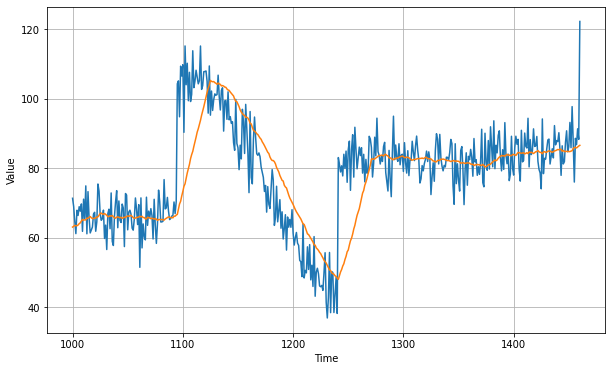

In [ ]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.674576
7.142419


That's worse than naive forecast! The moving average doesn´t anticipate trend or seasonality, so let´s try to remove them by using differencing. Since the seasonality period is 365 days, we will substract the value at time $t-365$ from the value at time $t$

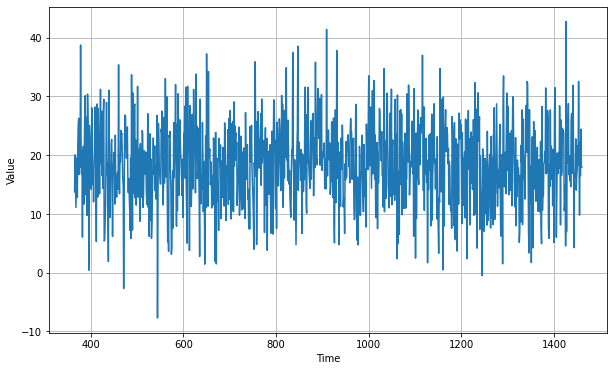

In [ ]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

Great, the trend and seasonality seem to be gone, so now we cn use the moving average:

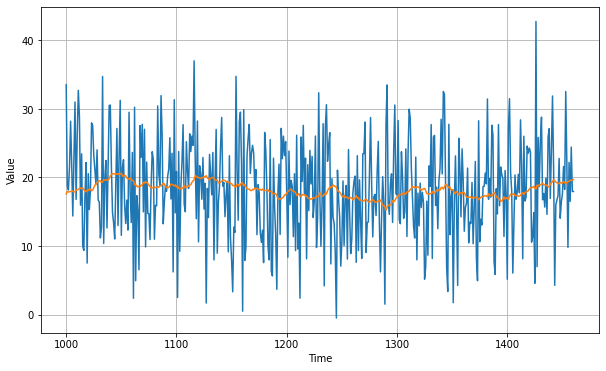

In [ ]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

Now let´s bring back the trend and seasonality by adding the past values from $t-365$

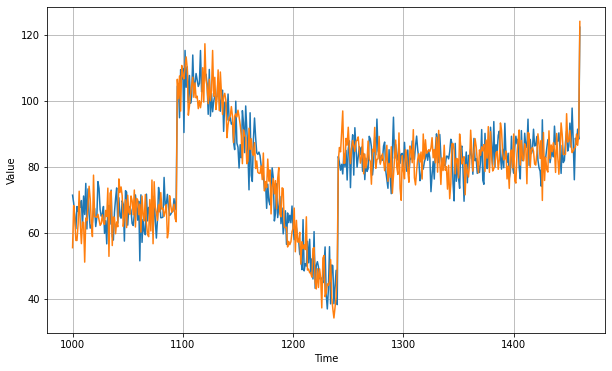

In [ ]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

52.97366
5.839311


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let´s use a moving averaging on past values to remove some of the noise:

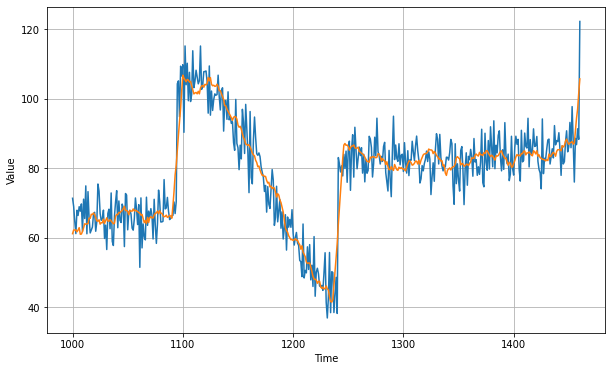

In [ ]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.45226
4.569442


Much better!

# Week 2

### 2.1.1. Preparing features and labels

Let's see what machine learning can do.

Let´s say that we are going to take a window of 30 days, then we would have those 30 days as features and the very next value would be a label

In [ ]:
import tensorflow as tf

dataset = tf.data.Dataset.range(10)
for val in dataset:
  print(val.numpy())

0
1
2
3
4
5
6
7
8
9


Let's make this a bit more interesting by using windows:

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


If we want regularly sized data:


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


Now let's put this into Numpy lists so that we can start using them in Machine Learning:

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder = True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


Next, we want to split data into features and labels:

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder = True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x, y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


We typically shuffle data before trainning:

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder = True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size = 10)     ### amount of items that we have
for x, y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[4 5 6 7] [8]
[5 6 7 8] [9]
[3 4 5 6] [7]


Finally we can batch the data:

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder = True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size = 10)     ### amount of items that we have
dataset = dataset.batch(2).prefetch(1)     ### batch data into sets of 2
for x, y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

x =  [[1 2 3 4]
 [2 3 4 5]]
y =  [[5]
 [6]]
x =  [[3 4 5 6]
 [4 5 6 7]]
y =  [[7]
 [8]]
x =  [[5 6 7 8]
 [0 1 2 3]]
y =  [[9]
 [4]]


**Sequence Bias**

Sequence bias is when the order of things can impact the selection of things. For example, if I were to ask you your favorite TV show, and listed "Game of Thrones", "Killing Eve", "Travellers" and "Doctor Who" in that order, you're probably more likely to select 'Game of Thrones' as you are familiar with it, and it's the first thing you see. Even if it is equal to the other TV shows. So, when training data in a dataset, we don't want the sequence to impact the training in a similar way, so it's good to shuffle them up.

### 2.1.2 Feeding windowed dataset into a neural network

Let's start with a function that will create a windowed dataset:

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  '''
  INPUT: series of data
  INPUT: size of the window
  INPUT: size of the batch
  INPUT: wether we want to shuffle or not
  OUTPUT: Windowed dataset
  '''
  ### Step 1: create a dataset from the series input
  dataset = tf.data.Dataset.from_tensor_slices(series)

  ### Step 2: slice data into windows, keeping them the same size
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

  ### Step 3: flatten data out making it easier to work with
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  ### Step 4: Once flattened, it is easier to shuffle ([:-1] is all except the last)
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))

  ### Step 5: apply batch
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

### 2.1.3. Single Layer Neural Network

The most simple one is a linear regression

Before we can do the training, we need to split our data into training and validation sets:


In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

Here is the code to do a simple **Linear Regression**:



In [ ]:
### Set the constants
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

### Create dataset
dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)

### Single layer in a variable l0
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])

### Define the model with the previous layer
model = tf.keras.models.Sequential([l0])

### Compile the model, optimizer is Stochastic Gradient Descent
### lr = learning rate
model.compile(loss="mse",
              optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=.09))

### Fit model by just passing the dataset
### We can ingnore the epoch by epoch output by setting verbose = 0
model.fit(dataset, epochs=100, verbose = 0)

### Once it's done training, inspect different weights
print("Layer weights {}".format(l0.get_weights()))

NameError: ignored

In this output, the value for the second array is the $b$ value

### 2.1.4. Prediction

We can do a standard linear regression considering:

$$Y = W_{t_0}X_{0} + W_{t_{1}}X_{1} + ... + W_{t_{19}}X_{19} + b$$

In [ ]:
print(series[1:21])

### In order to predict
model.predict(series[1:21][np.newaxis])

If we wanted to plot our forecast:

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]


### 2.1.5. More on single layer neural network

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.02262932],
       [ 0.00152513],
       [ 0.0322467 ],
       [-0.05009501],
       [ 0.04764396],
       [-0.01318894],
       [-0.02126941],
       [ 0.04313006],
       [-0.03807881],
       [ 0.03957637],
       [ 0.02854978],
       [-0.07390832],
       [-0.01050956],
       [ 0.02331689],
       [ 0.02770507],
       [ 0.11468875],
       [-0.06684726],
       [ 0.2436807 ],
       [ 0.21604723],
       [ 0.4695629 ]], dtype=float32), array([0.010929], dtype=float32)]


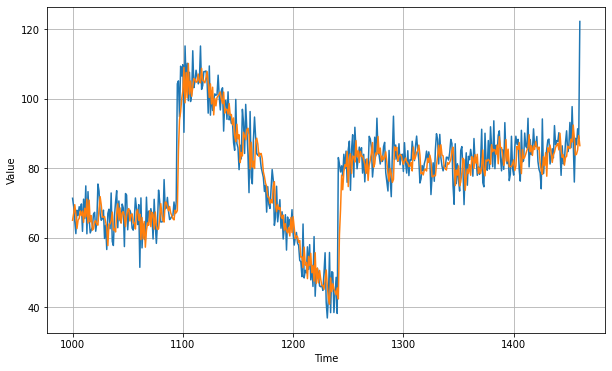

In [ ]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.998384

### 2.1.6. Deep Neural Network training, tuning and prediction

In code, it would look something like this:

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10, input_shape = [window_size], activation = "relu"),
                                    tf.keras.layers.Dense(10, activation = "relu")
                                    tf.keras.layers.Dense(1)
])

model.compile(loss = "mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs = 100, verbose = 0)


Wouldn´t it be nice to pick the optimal learning rate instead of the one that we chose?

A technique for this is using *callbacks*:

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10, input_shape = [window_size], activation = "relu"),
                                    tf.keras.layers.Dense(10, activation = "relu")
                                    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(loss = "mse", optimizer = optimizer)

history = model.fit(dataset, epochs = 100, callbacks=[lr_schedule])



We can then plot the loss per epoch against the learning rate per epoch using this code:

In [ ]:
lrs = 1e-8 * (10**(np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])


Then we can try and pick the lowest point of the curve where it is still relatively stable. We can then set that as the value of our optimal learning rate and retrain using it:

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10, input_shape = [window_size], activation = "relu"),
                                    tf.keras.layers.Dense(10, activation = "relu")
                                    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9)

model.compile(loss = "mse", optimizer = optimizer)

history = model.fit(dataset, epochs = 500)


To plot the loss calculated during the training, use the following code:

In [ ]:
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, loss, 'b', label="Training Loss")
plt.show()

### 2.1.7. Deep Neural Network

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

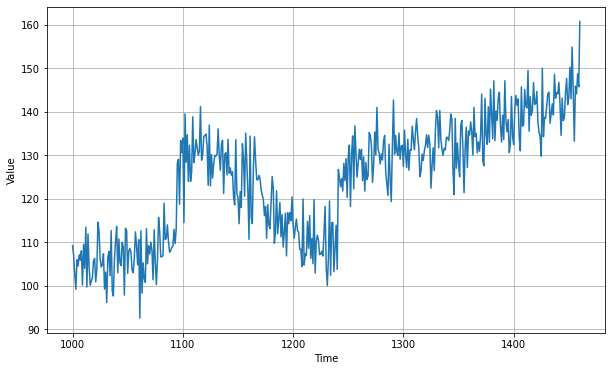

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


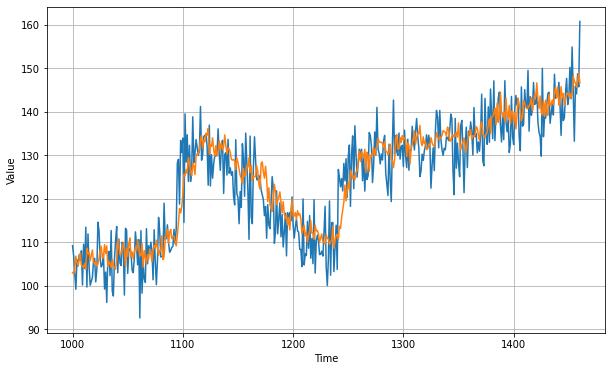

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7675977

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

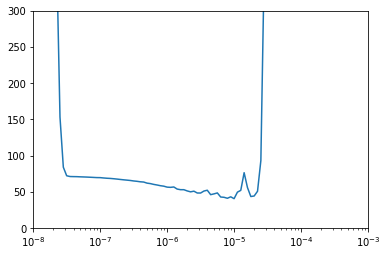

In [ ]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [ ]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

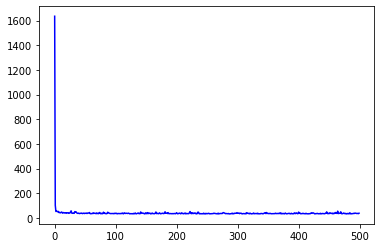

In [ ]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[41.876853942871094, 47.237850189208984, 45.40058898925781, 38.1846809387207, 42.351539611816406, 42.93942642211914, 39.36894989013672, 40.53560256958008, 42.112754821777344, 37.396278381347656, 41.28680419921875, 40.48993682861328, 42.05670166015625, 37.14784622192383, 38.7452278137207, 39.289520263671875, 48.10099411010742, 57.11269760131836, 38.66205596923828, 37.26970291137695, 37.990509033203125, 38.094024658203125, 36.966251373291016, 50.807289123535156, 47.76081085205078, 49.29339599609375, 41.32177734375, 37.938255310058594, 36.46726989746094, 38.76028823852539, 35.99319839477539, 34.95615768432617, 37.31575393676758, 37.18327713012695, 38.8006477355957, 35.896644592285156, 34.7286262512207, 37.92506790161133, 38.06383514404297, 35.126399993896484, 37.149627685546875, 37.66875457763672, 38.542945861816406, 35.43425369262695, 38.68049621582031, 38.654056549072266, 40.05202865600586, 43.40879440307617, 35.19782638549805, 33.816871643066406, 34.936851501464844, 34.3757438659668, 3

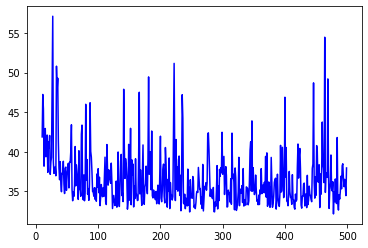

In [ ]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

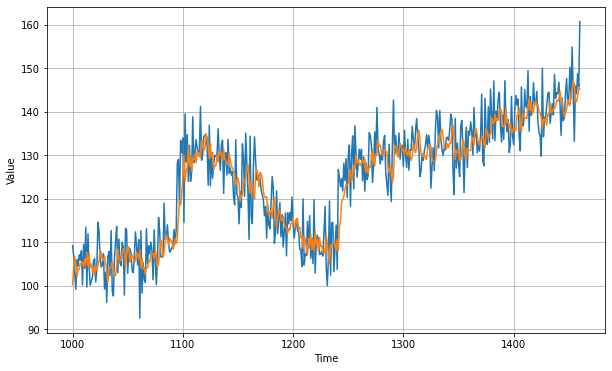

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.569243

# Week 3

## 3.1.1. Conceptual Overview



Input windows $X$ $\rightarrow$ Recurrent Layer $\rightarrow$ Recurrent Layer $\rightarrow$ Dense Layer $\rightarrow$ $\hat{Y}$ forecasts

Can be used to process the series.

Input shape in this case is 3-dimensional:

- shape = [batch_size, # time steps, # dims]

The logic behind is that, for example, taking the input $X_{0}$, passing it to the memory cell results in output $\hat{Y_{0}}$, which then can be passed on to the next cell as $H_{0}$ and so on

## 3.1.2. Shape of the inputs to the RNN


Here is an example:

- If we have a window size of 30 time steps and we´re batching them in batches of 4, the shape will be [4, 30, 1]

- At each time step the memory cell input will be a 4x1 matrix

- If the memory cell is comprised by 3 neuros, the the output $\hat{Y}$ will have a shape of 4x3, so the full output is 3-dimensional, in this case 4x30x3, with 4 being the batch size, 3 being the number of units and 30 being the number of overall steps.

- $H$ is just a copy of $\hat{Y}$






## 3.1.3. Outputting a sequence

Consider the following RNN:

In [ ]:
model = keras.models.Sequential([
                                 keras.layers.SimpleRNN(20, return_sequences = True,
                                                        input_shape = [None, 1]),
                                 keras.layers.SimpleRNN(20),
                                 keras.layers.Dense(1)
])

Notice the input shape is [None, 1], this is because TensorFlow asumes the first entry to be the batch size. The last dimension is jjst $1$ because we´re using an univariate series.

If we set *return_sequences* to True, then our RNN will output sequences. By removing this, we get an output of a single Dense.


## 3.1.4. Lambda Layers

In [ ]:
model = keras.models.Sequential([
                                 keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1),
                                                     input_shape = [None]),
                                 keras.layers.SimpleRNN(20, return_sequences=True),
                                 keras.layers.SimpleRNN(20),
                                 keras.layers.Dense(1),
                                 keras.layers.Lambda(lambda x: x * 100)
])

We can fix shapes with this technique

## 3.1.5. Ajusting the Learning Rate Dynamically

To tune the learning rate, we'll setup a *callback*:


In [ ]:
train_set = windowed_dataset(x_train, window_size, batch_size = 128, shuffler_buffer = shuffler_buffer_size)

model = tk.keras.models.Sequential([
                                    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape = [None])
                                    tk.keras.layers.SimpleRNN(40, return_sequences=True),
                                    tf.keras.layers.SimpleRNN(40),
                                    tk.keras.layers.Dense(1),
                                    tk.keras.layers.Lambda(lambda x: x *100)
])

lr_shcedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)

model.compile(loss=tk.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Here it would be helpful to read about Huber Loss

## 3.1.6. RNN

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 16ms/step - loss: 195.5726 - mae: 196.0726 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 194.7820 - mae: 195.2820 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 193.5109 - mae: 194.0109 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 191.9081 - mae: 192.4081 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 190.0235 - mae: 190.5235 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 187.8582 - mae: 188.3582 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 185.3786 - mae: 185.8786 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 12ms/step - loss: 182.5483 - mae: 183.0483 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 179.3126 - mae: 

(1e-08, 0.0001, 0.0, 30.0)

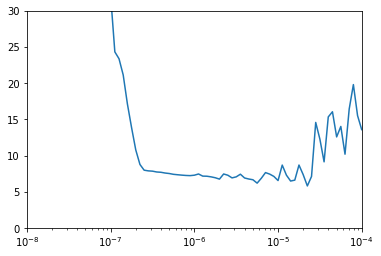

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 0s 12ms/step - loss: 81.7535 - mae: 82.2535
Epoch 2/400
8/8 [==============================] - 0s 11ms/step - loss: 21.9358 - mae: 22.4301
Epoch 3/400
8/8 [==============================] - 0s 13ms/step - loss: 15.9200 - mae: 16.4143
Epoch 4/400
8/8 [==============================] - 0s 11ms/step - loss: 12.2879 - mae: 12.7814
Epoch 5/400
8/8 [==============================] - 0s 10ms/step - loss: 10.1503 - mae: 10.6405
Epoch 6/400
8/8 [==============================] - 0s 11ms/step - loss: 16.3163 - mae: 16.8110
Epoch 7/400
8/8 [==============================] - 0s 11ms/step - loss: 13.7287 - mae: 14.2229
Epoch 8/400
8/8 [==============================] - 0s 10ms/step - loss: 9.6225 - mae: 10.1128
Epoch 9/400
8/8 [==============================] - 0s 13ms/step - loss: 8.9765 - mae: 9.4663
Epoch 10/400
8/8 [==============================] - 0s 14ms/step - loss: 7.9001 - mae: 8.3863
Epoch 11/400
8/8 [==============================] - 0s

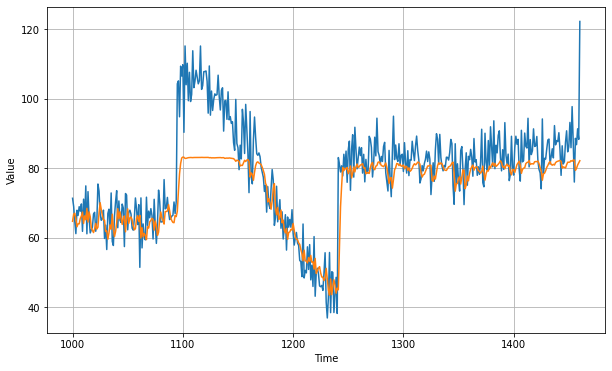

In [ ]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.824173

<Figure size 432x288 with 0 Axes>

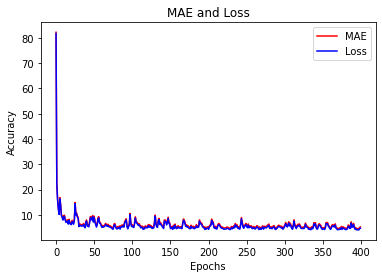

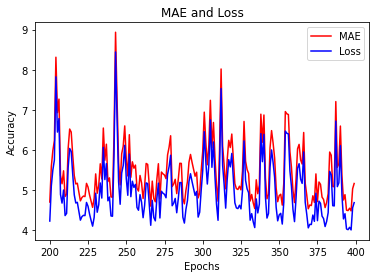

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

## 3.1.7. LSTM

This implies preserving a state a passes on from cell to cell

Let´s look at some code with LSTM:

In [ ]:
### Clears any internal variables
tk.keras.backend.clear_session()

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),
                                                           input_shape=[None]),
                                    
                                    ### Bidirectional to see the impact
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)
                                    tf.keras.layers.Bidirectional(tk.keras.layers.LSTM(32)),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 100)

])

model.compile(loss="mse", optimizer=tk.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose = 0)


## 3.1.8. More on LSTM

Just in case we need to force installation of tensorflow:

In [ ]:
!pip install tf-nightly-2.0-preview


ERROR: Could not find a version that satisfies the requirement tf-nightly-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-2.0-preview


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 28ms/step - loss: 21.5167 - mae: 22.0115 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 26ms/step - loss: 21.1522 - mae: 21.6444 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 27ms/step - loss: 20.7302 - mae: 21.2236 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 27ms/step - loss: 20.2834 - mae: 20.7757 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 27ms/step - loss: 19.7897 - mae: 20.2855 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 26ms/step - loss: 19.1782 - mae: 19.6696 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 28ms/step - loss: 18.2410 - mae: 18.7333 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 27ms/step - loss: 17.4825 - mae: 17.9748 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 26ms/step - loss: 17.1597 - mae:

(1e-08, 0.0001, 0.0, 30.0)

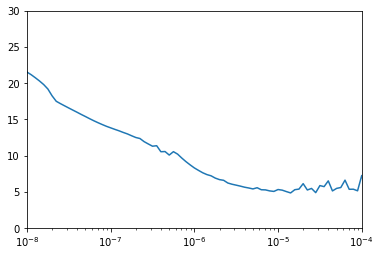

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

Seems that a good learning rate is $10^{-5}$

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

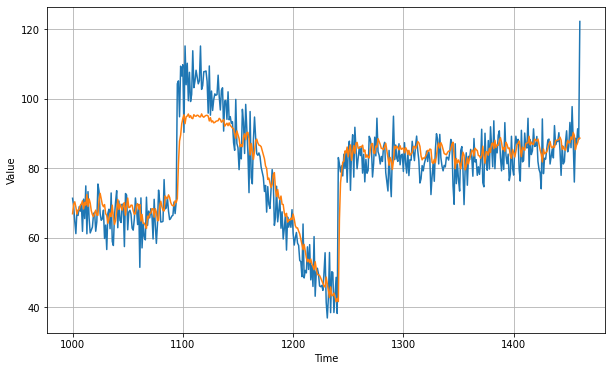

In [ ]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.450017

<Figure size 432x288 with 0 Axes>

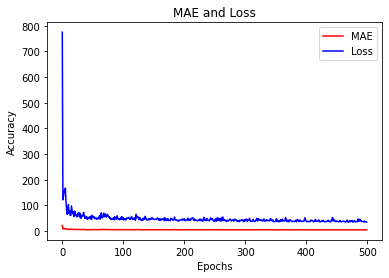

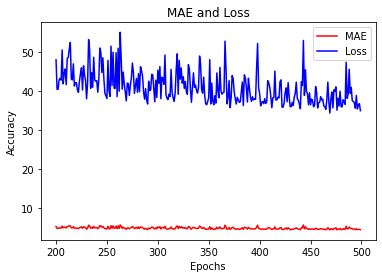

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, verbose=0)

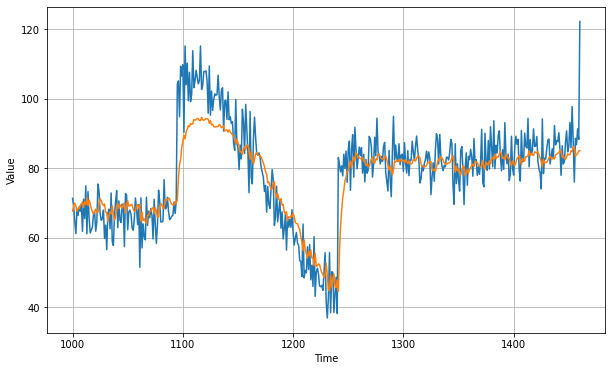

In [ ]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.6102567

<Figure size 432x288 with 0 Axes>

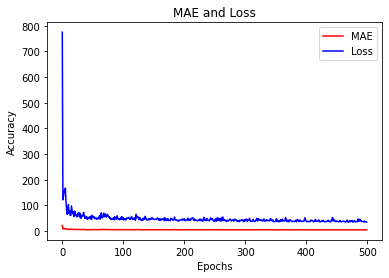

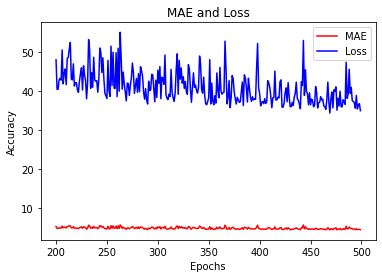

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 40ms/step - loss: 755.7013
Epoch 2/100
31/31 [==============================] - 1s 39ms/step - loss: 152.7785
Epoch 3/100
31/31 [==============================] - 1s 40ms/step - loss: 97.9761
Epoch 4/100
31/31 [==============================] - 1s 41ms/step - loss: 83.2915
Epoch 5/100
31/31 [==============================] - 1s 40ms/step - loss: 78.2600
Epoch 6/100
31/31 [==============================] - 1s 39ms/step - loss: 73.4347
Epoch 7/100
31/31 [==============================] - 1s 40ms/step - loss: 67.8632
Epoch 8/100
31/31 [==============================] - 1s 39ms/step - loss: 74.5354
Epoch 9/100
31/31 [==============================] - 1s 39ms/step - loss: 73.1458
Epoch 10/100
31/31 [==============================] - 1s 41ms/step - loss: 63.4809
Epoch 11/100
31/31 [==============================] - 1s 39ms/step - loss: 60.9757
Epoch 12/100
31/31 [==============================] - 1s 38ms/step - loss: 57.7044
Epoch 13/10

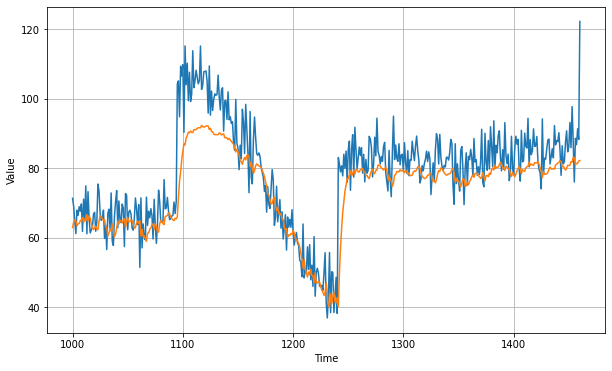

In [ ]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.413979

<Figure size 432x288 with 0 Axes>

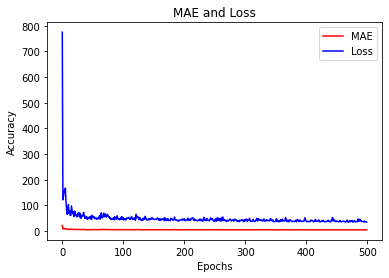

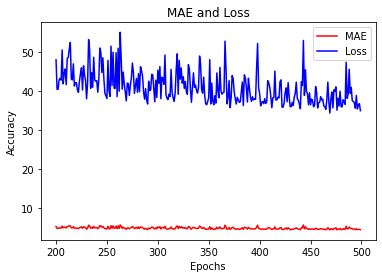

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# Week 4

Now we'll use real world sunspot data.

## 4.1.1. Convolutions


We'll combine Convolutions with LSTM.

We'll try to learn 32 filters.

Here's some code:

In [ ]:
model = tf.keras.models.Sequential([
                                    tk.keras.layers.Conv1D(filters=32,
                                                           kernel_size=5,
                                                           strides=1,
                                                           padding="casual",
                                                           activation="relu",
                                                           input_shape=[None, 1]),
                                    tf.keras.layers.LSTM(32, return_sequences=True),
                                    tf.keras.layers.LSTM(32, return_sequences=True),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 200)

])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(loss=tf.keras.loses.Huber(),
              optimizer = optimizer,
              metrics=["mae"])

model.fit(dataset.epochs=500)

Notice we got rid of the Lambda layer that reshaped the input for us to work with the LSTM, so we specify the input shape in the Conv1D.

This requires us to update the windowed_dataset helper function that we've been working with all along.

We'll simply use *tf.expand_dims* in the helper function to expand the dimensions of the series before we process it.



In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)

  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder = True)
  ds = ds.flat_map(lambda w: 2.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))

  return ds.batch(batch_size).prefetch(1)


Sometimes the reason that we observe peaks in the loss plots is a small sized batch

## 4.1.2. LSTM

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 1s 75ms/step - loss: 73.1912 - mae: 73.6903 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 1s 67ms/step - loss: 72.4799 - mae: 72.9791 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 1s 66ms/step - loss: 71.3446 - mae: 71.8437 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 1s 72ms/step - loss: 69.9230 - mae: 70.4223 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 1s 74ms/step - loss: 68.2678 - mae: 68.7669 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 1s 66ms/step - loss: 66.3621 - mae: 66.8609 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 1s 66ms/step - loss: 64.2432 - mae: 64.7424 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 1s 66ms/step - loss: 61.8749 - mae: 62.3738 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 1s 69ms/step - loss: 59.2491 - mae: 59.7479 - lr: 2.5

(1e-08, 0.0001, 0.0, 30.0)

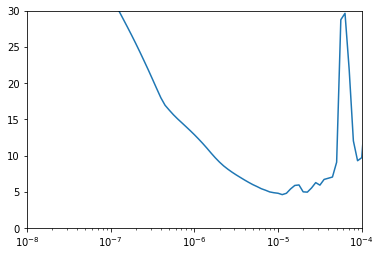

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 1s 27ms/step - loss: 20.0714 - mae: 20.5646
Epoch 2/500
31/31 [==============================] - 1s 28ms/step - loss: 7.9198 - mae: 8.4048
Epoch 3/500
31/31 [==============================] - 1s 30ms/step - loss: 6.6716 - mae: 7.1533
Epoch 4/500
31/31 [==============================] - 1s 29ms/step - loss: 6.1672 - mae: 6.6477
Epoch 5/500
31/31 [==============================] - 1s 32ms/step - loss: 5.7152 - mae: 6.1947
Epoch 6/500
31/31 [==============================] - 1s 34ms/step - loss: 5.6691 - mae: 6.1493
Epoch 7/500
31/31 [==============================] - 1s 33ms/step - loss: 5.5057 - mae: 5.9846
Epoch 8/500
31/31 [==============================] - 1s 29ms/step - loss: 5.4893 - mae: 5.9692
Epoch 9/500
31/31 [==============================] - 1s 30ms/step - loss: 5.5435 - mae: 6.0236
Epoch 10/500
31/31 [==============================] - 1s 30ms/step - loss: 5.2388 - mae: 5.7178
Epoch 11/500
31/31 [===========================

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

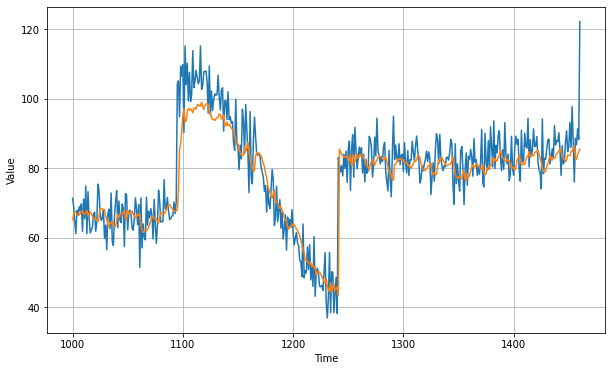

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.091009

<Figure size 432x288 with 0 Axes>

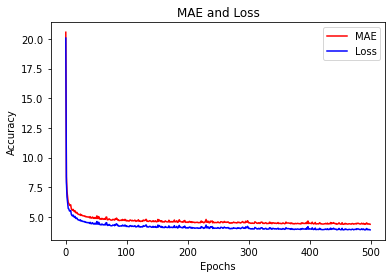

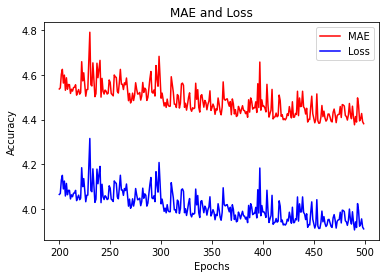

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

## 4.1.3. Real data - Sunspots

This dataset is in Kaggle, although Lawrence has uploaded it for quick acces into Colab, downloading it is recommended.

Here's the code to read it:

In [ ]:
!wget --no-check-certificate \
     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
     -0 /tmp/sunspots.csv

Then, this code will read the csv file:

In [ ]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter= ',')
  next(reader)     ### this line skips the first one, since that contains names of columns
  for row in reader:
    sunspots.append(float(row[2]))     ### sunspot data is in column 2
    time_step.append(int(row[0]))

In order to perform Machine Learning on our data, we will need it to be in numpy arrays, so now we change it:

In [ ]:
series = np.array(sunspots)
time = np.array(time_step)

It's better to do it this way, by first creating throwaway lists and converting them to Numpy, because starting with Numpy arrays implies heavy computational costs every time an item is added.

We then split our data into training and avalidation datasets:

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

## 4.1.4. Train and Tune the Model

A window size of 20 seems to give us a high MAE, so we need to change it to about 132 (11 years worth of data).

But this will result in a much higher MAE, so this is not the solution!

Maybe we don´t need a huge window of time, so now let´s try 30.

Let's also make it 3000 in our training data.


## 4.1.5. Prediction

Out of interest, let's do a prediction. The window size I'm using is 30 steps, and the dataset is 3,235 steps long. So if I want to predict the next value after the end of my dataset, I would use this code:

In [ ]:
model.predict(series[3205:3235][np.newaxis])

The result we get is 7.0773993

The dataset goes up to July 2018, so I'm actually predicting 7.077 sunspots for August 2018. And if we look at this chart of observations, which does have some slightly different data from my dataset, I can see that the actual recorded number of susnspots in August 2018 was 8.7. So the prediction isn´t too bad, but let´s see if we can improve on it.

In [ ]:
split_time = 3000
window_size = 60

model = tf.keras.models.Sequential([
                                    tf.keras.layerss.Dense(20, input_shape=[window_size], activation = "relu"),
                                    tf.keras.layers.Dense(10, activation = "relu"),
                                    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum = 0.9))


With the previous code we manage to get the MAE to 13.75 and the prediction was 8.13 which is closer.

## 4.1.6. Sunspots

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-07-25 05:10:57--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-07-25 05:10:57 (103 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



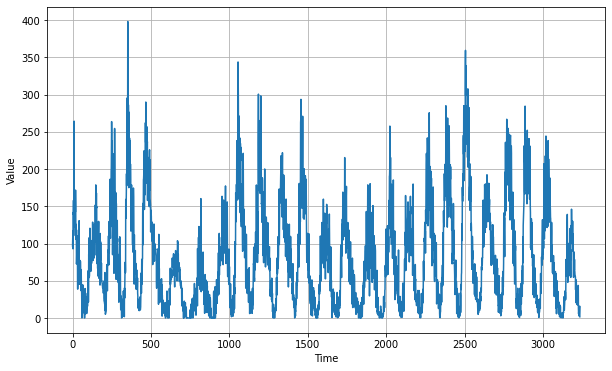

In [ ]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

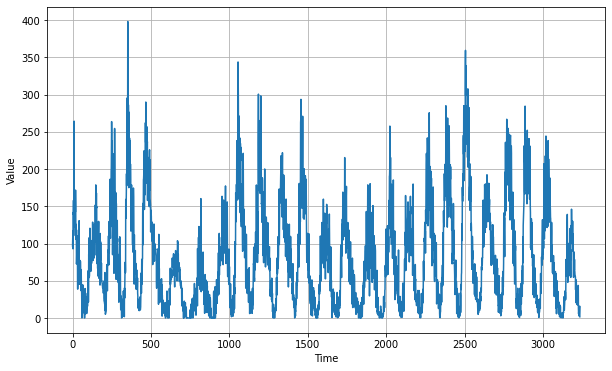

In [ ]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 4s 324ms/step - loss: 79.8340 - mae: 80.3314 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 4s 330ms/step - loss: 78.0944 - mae: 78.5918 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 4s 332ms/step - loss: 75.4519 - mae: 75.9497 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 4s 329ms/step - loss: 72.2679 - mae: 72.7658 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 4s 314ms/step - loss: 68.7693 - mae: 69.2672 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 4s 322ms/step - loss: 65.1128 - mae: 65.6099 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 4s 301ms/step - loss: 61.5272 - mae: 62.0241 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 4s 328ms/step - loss: 58.1406 - mae: 58.

(1e-08, 0.0001, 0.0, 60.0)

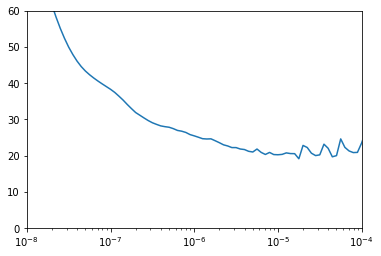

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 4s 139ms/step - loss: 38.9180 - mae: 39.4144
Epoch 2/500
30/30 [==============================] - 4s 138ms/step - loss: 25.7652 - mae: 26.2597
Epoch 3/500
30/30 [==============================] - 4s 140ms/step - loss: 22.0764 - mae: 22.5701
Epoch 4/500
30/30 [==============================] - 4s 143ms/step - loss: 20.4601 - mae: 20.9529
Epoch 5/500
30/30 [==============================] - 4s 143ms/step - loss: 19.7085 - mae: 20.2010
Epoch 6/500
30/30 [==============================] - 4s 142ms/step - loss: 19.3149 - mae: 19.8069
Epoch 7/500
30/30 [==============================] - 4s 143ms/step - loss: 18.7104 - mae: 19.2024
Epoch 8/500
30/30 [==============================] - 4s 143ms/step - loss: 18.1212 - mae: 18.6128
Epoch 9/500
30/30 [==============================] - 4s 144ms/step - loss: 18.0739 - mae: 18.5654
Epoch 10/500
30/30 [==============================] - 4s 141ms/step - loss: 17.9504 - mae: 18.4419
Epoch 11/500
30/30 

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

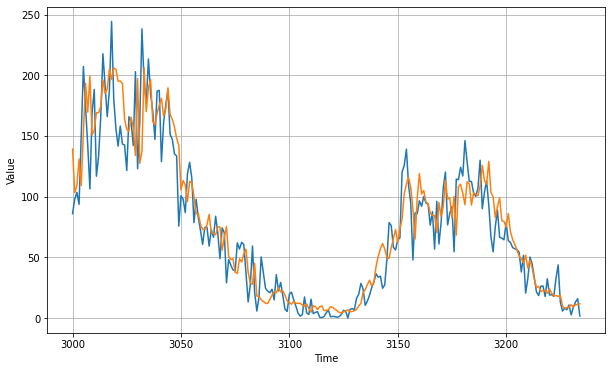

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.578633

<Figure size 432x288 with 0 Axes>

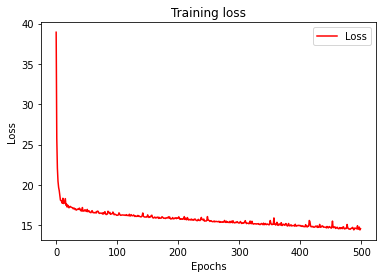

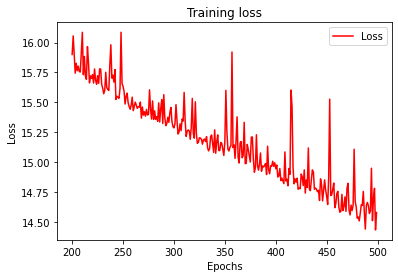

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)

[139.15103   103.257835  109.05441   130.89359   109.08462   153.4178
 193.28883   169.61122   199.3232    150.79306   154.66577   169.05086
 169.09581   174.28943   196.14844   185.09811   188.71524   205.1584
 196.61856   205.9072    205.13411   195.09193   195.27954   193.3103
 163.65907   155.46349   154.00629   165.5151    156.76578   133.8541
 197.17648   127.373795  137.33426   206.31989   170.01204   189.91432
 196.48901   161.69543   159.36363   168.61568   175.33371   180.99873
 166.26727   172.3437    189.59187   167.59026   163.6562    157.51883
 148.23448   142.09087   105.39492   113.20199   109.50565    95.979294
 112.715485  111.28803   100.15172    85.86907    85.80721    77.29033
  72.82231    73.21491    76.67298    85.29858    70.444885   69.41023
  68.492294   75.16827    74.93472    55.85606    66.53521    75.39296
  50.745155   48.12284    48.85459    37.720516   36.613567   48.817368
  46.141277   52.880486   56.690193   37.65856    28.604954   27.822231
  45.03

And if we wanted to only use DNN's:

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


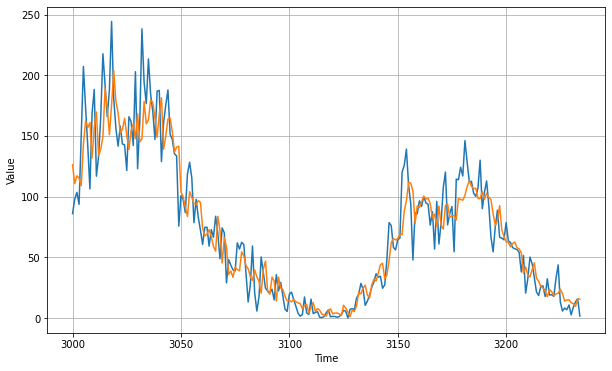

In [ ]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.793581